<a href="https://colab.research.google.com/github/mkandaleft/COMP432-GroupM/blob/main/Comp432.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic includes.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.metrics
import torch
import torchvision
import random
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import zipfile

# Use the GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Task 1

In [ ]:

# Download and unzip the first dataset.
#!gdown 1ezX0lJaB8atZesMns4cGHR3pXkRTEKSt # Roxane: I put the dataset on my Drive for ease of downloading.

with zipfile.ZipFile("Dataset1.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

data_path = "Dataset 1/Colorectal Cancer "


In [ ]:
# Load the data to a torch tensor.

# Code partly provided by the outline for assignment 1.
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Data normalization done here.
dataset = torchvision.datasets.ImageFolder(data_path, transforms) # Load the images and their labels into a tensor.

train_set, test_set = torch.utils.data.random_split(dataset, [0.7,0.3]) # Split the dataset into training and testing set.

batch_size = 100 # What batch size do we want?
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size)#, num_workers=2) # Create train loader. The multiple workers were being a fuck :/
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True)#, num_workers=2) # Create test loader.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) 2


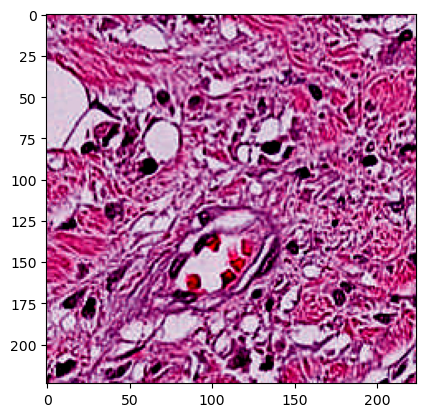

In [ ]:
# Look at a random sample from the normalized training set.
index = random.randint(0, len(train_set))
image, label = train_set[index]
plt.imshow(image.numpy().transpose(1, 2, 0))
print(image.shape, label)

# Instead, print the same image before and after loading in the dataset?

# Preprocess the data.
# Do we need to do data augmentation?

In [ ]:
## Declare the model
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

resnet18 = torchvision.models.resnet18() # Do we need any special parameters?
resnet18 = resnet18.to(device)

In [ ]:
# Train the model with the dataset.

learning_rate = 0.0025
num_epoch = 20

loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(resnet18.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.001) # Customize other params?
#optimizer = torch.optim.Adam(resnet18.parameters(), lr = learning_rate) # Should we use adam instead of SGD? It didn't give good results when I tried.

next_epoch = 1
for epoch in range(next_epoch, next_epoch+num_epoch):
    resnet18.train()

    for i, batch in enumerate(train_loader, 0):
        X, y = batch

        X = X.to(device)
        y = y.to(device)

        y_pred = resnet18(X)
        loss = loss_function(y_pred, y)

        resnet18.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch %2d: loss on final training batch: %.4f" % (epoch, loss.item()))

next_epoch = epoch+1

In [ ]:
# Save / Export the model and its weights.

torch.save(resnet18, "resnet18_model.pth")
torch.save(resnet18.state_dict(), "resnet18_weights.pth")

In [ ]:
# Load the pre-trained moved.
# Load the pre-trained model on the CPU.
checkpoint = torch.load("resnet18_weights.pth")
resnet18.load_state_dict(checkpoint)

Classification report for the training set:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1419
           1       0.99      1.00      0.99      1377
           2       0.96      0.99      0.98      1404

    accuracy                           0.98      4200
   macro avg       0.98      0.98      0.98      4200
weighted avg       0.98      0.98      0.98      4200


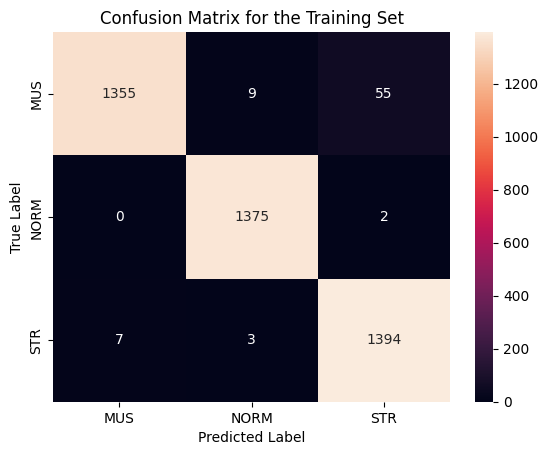


Classification report for the testing set:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       581
           1       0.99      1.00      1.00       623
           2       0.96      0.99      0.98       596

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800


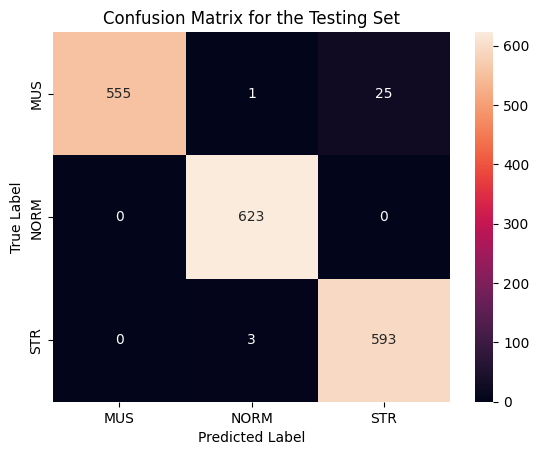

In [ ]:
# Testing time!

# Roxane: I mostly copied the work I'd done for my assignment 1, so we'll likely need to modify this, have it print more info, etc.

resnet18.eval()

# Test and report on the training data.
y_train_true = []
y_train_pred = []

for data in train_loader:
  train_inputs, train_labels = data
  train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
  y_train_true.extend(train_labels.tolist())

  output = torch.softmax(resnet18(train_inputs), dim=1)
  y_train_pred.extend(output.argmax(dim=1).cpu().numpy().tolist())

class_report_train = sklearn.metrics.classification_report(y_train_true, y_train_pred)
print("Classification report for the training set:")
print(class_report_train)
#print("\nConfusion matrix for the training set:\nMUS, NORM, STR")
#print(sklearn.metrics.confusion_matrix(y_train_true, y_train_pred))

# Display the confusion matrix as a fancy picture.
class_labels = ["MUS", "NORM", "STR"]
cm_train = sklearn.metrics.confusion_matrix(y_train_true, y_train_pred)

sns.heatmap(cm_train, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for the Training Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Test and report on the testing data.
y_test_true = []
y_test_pred = []

for data in test_loader:
  test_inputs, test_labels = data
  test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
  y_test_true.extend(test_labels.tolist())

  output = torch.softmax(resnet18(test_inputs), dim=1)
  y_test_pred.extend(output.argmax(dim=1).cpu().numpy().tolist())

class_report_test = sklearn.metrics.classification_report(y_test_true, y_test_pred)
print("\nClassification report for the testing set:")
print(class_report_test)
#print("\nConfusion matrix for the testing set:\nMUS, NORM, STR")
#print(sklearn.metrics.confusion_matrix(y_test_true, y_test_pred))

# Display the confusion matrix as a fancy picture.
cm_test = sklearn.metrics.confusion_matrix(y_test_true, y_test_pred)

sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for the Testing Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

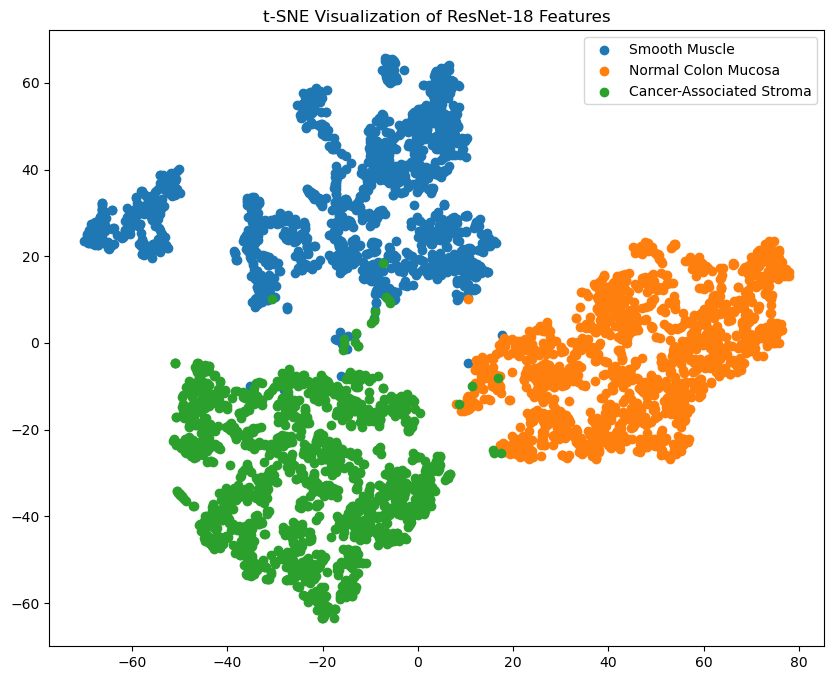

In [ ]:
resnet18.eval()

# Store features and labels
features_list = []
labels_list = []

# Get the features and labels
for data in train_loader:
    train_inputs, train_labels = data
    train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
    features = resnet18(train_inputs).detach().cpu().numpy()
    features_list.append(features)
    labels_list.append(train_labels.cpu().numpy())

# Concatenate features and labels
features = torch.from_numpy(np.concatenate(features_list))
labels = torch.from_numpy(np.concatenate(labels_list))

# Reshape the features tensor if needed
features = features.view(features.size(0), -1)  # Reshape if necessary for t-SNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(features)

# Verbal class labels.
class_labels =["Smooth Muscle", "Normal Colon Mucosa", "Cancer-Associated Stroma"]

# Plot the t-SNE embedded features with class labels
plt.figure(figsize=(10, 8))
for class_idx in range(3):
    plt.scatter(
        embedded_features[labels == class_idx, 0],
        embedded_features[labels == class_idx, 1],
        label=class_labels[ class_idx],
    ) # How to switch the labels to "mus", "norm" and "str"?
plt.title('t-SNE Visualization of ResNet-18 Features')
plt.legend()
plt.show()

# Task 2

### Analyze and visualize feature extraction done by pre-trained CNN encoder from Task 1 when applied to Dataset 2 and Dataset 3

#### Dataset 2

In [ ]:
# Load the pre-trained ResNet-18 CNN model trained in Task 1
checkpoint =  torch.load("resnet18_weights.pth", map_location=torch.device('cpu'))
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.load_state_dict(checkpoint)

/home/mkandaleft/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mkandaleft/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
# Create a folder 'content' in root and add Dataset 2 and Dataset 3 folders

# Download Dataset 2
data_path_2 = 'content/Dataset 2/Prostate Cancer'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset_2 = torchvision.datasets.ImageFolder(data_path_2, transforms)

batch_size = 100
data_loader_2 = torch.utils.data.DataLoader(dataset_2, shuffle=True, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 300, 300]) 1


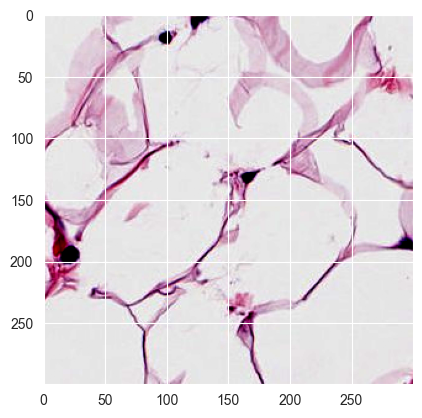

In [ ]:
# Visualize a random sample from the normalized dataset
index = random.randint(0, len(dataset_2))
image, label = dataset_2[index]
plt.imshow(image.numpy().transpose(1, 2, 0))
print(image.shape, label)

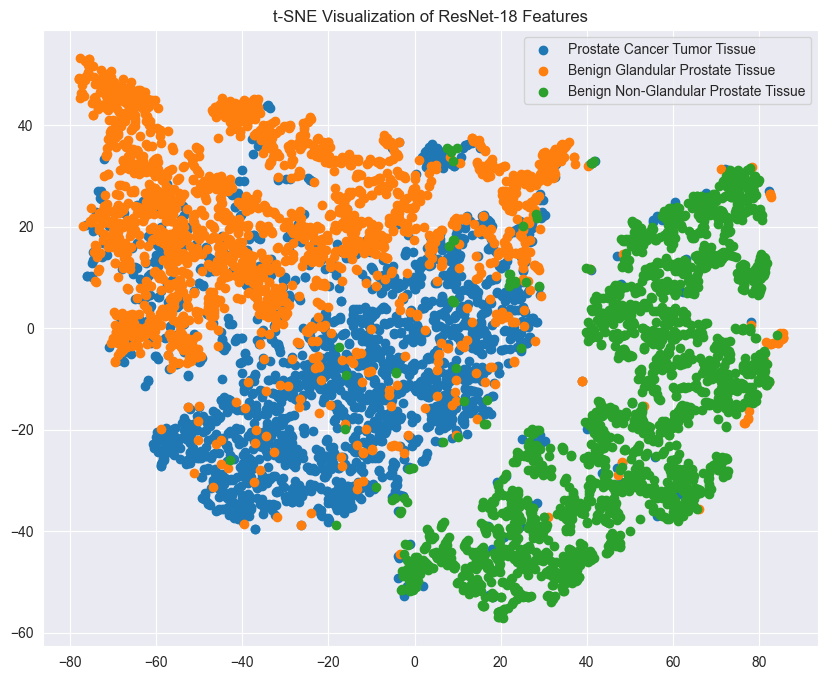

In [ ]:

resnet18.eval()

# Store features and labels
features_list = []
labels_list = []

# Get the features and labels
for data in data_loader_2:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    features = resnet18(inputs).detach().cpu().numpy()
    features_list.append(features)
    labels_list.append(labels.cpu().numpy())

# Concatenate features and labels
features = torch.from_numpy(np.concatenate(features_list))
labels = torch.from_numpy(np.concatenate(labels_list))

# Save the features and labels for learning tasks
np.save('extracted_features.npy', features.numpy())
np.save('labels.npy', labels.numpy())

# Reshape the features tensor if needed
features = features.view(features.size(0), -1)  # Reshape if necessary for t-SNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(features)

# Verbal class labels.
class_labels = ["Prostate Cancer Tumor Tissue", "Benign Glandular Prostate Tissue", "Benign Non-Glandular Prostate Tissue"]

# Plot the t-SNE embedded features with class labels
plt.figure(figsize=(10, 8))
for class_idx in range(3):
    plt.scatter(
        embedded_features[labels == class_idx, 0],
        embedded_features[labels == class_idx, 1],
        label=class_labels[ class_idx],
    )
plt.title('t-SNE Visualization of ResNet-18 Features')
plt.legend()
plt.show()

#### Dataset 3

In [ ]:
# Download Dataset 3
data_path_3 = 'Dataset 3/Animal Faces'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset_3 = torchvision.datasets.ImageFolder(data_path_3, transforms)

batch_size = 100
data_loader_3 = torch.utils.data.DataLoader(dataset_3, shuffle=True, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) 2


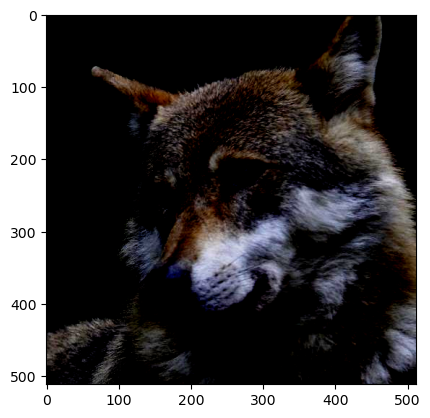

In [ ]:
# Visualize a random sample from the normalized dataset
index = random.randint(0, len(dataset_3))
image, label = dataset_3[index]
plt.imshow(image.numpy().transpose(1, 2, 0))
print(image.shape, label)

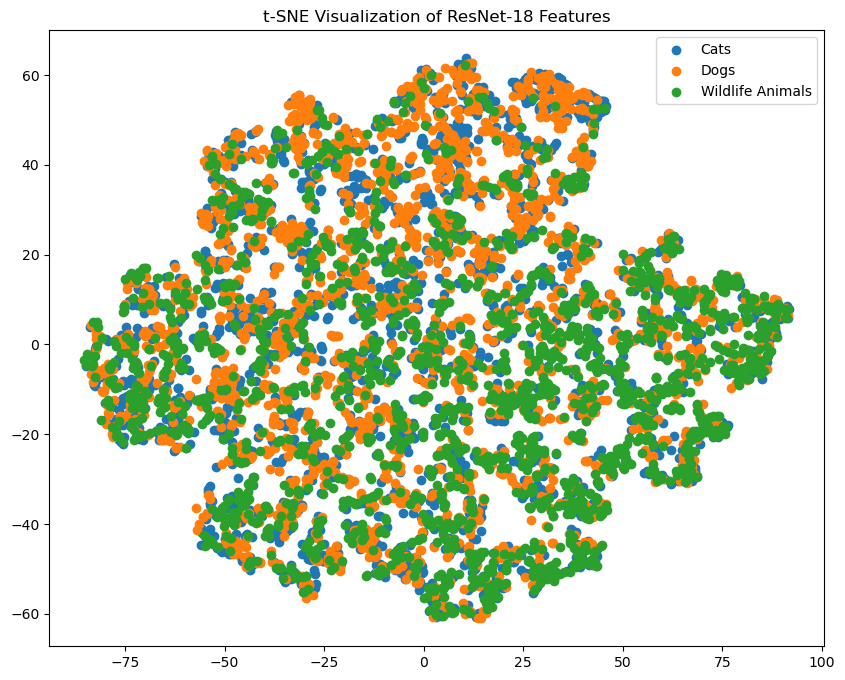

In [ ]:

resnet18.eval()

# Store features and labels
features_list = []
labels_list = []

# Get the features and labels
for data in data_loader_3:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    features = resnet18(inputs).detach().cpu().numpy()
    features_list.append(features)
    labels_list.append(labels.cpu().numpy())

# Concatenate features and labels
features = torch.from_numpy(np.concatenate(features_list))
labels = torch.from_numpy(np.concatenate(labels_list))

# Reshape the features tensor if needed
features = features.view(features.size(0), -1)  # Reshape if necessary for t-SNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(features)

# Verbal class labels.
class_labels = ["Cats", "Dogs", "Wildlife Animals"]

# Plot the t-SNE embedded features with class labels
plt.figure(figsize=(10, 8))
for class_idx in range(3):
    plt.scatter(
        embedded_features[labels == class_idx, 0],
        embedded_features[labels == class_idx, 1],
        label=class_labels[ class_idx],
    )
plt.title('t-SNE Visualization of ResNet-18 Features')
plt.legend()
plt.show()

Resnet50 Trained on ImageNet Feature extraction Dataset 2

In [ ]:
# Load the pre-trained ResNet-50 pretrained on ImageNet
resnet50 = torchvision.models.resnet50(weights='IMAGENET1K_V1')

In [ ]:
data_path_2 = 'Dataset 2/Prostate Cancer'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset_2 = torchvision.datasets.ImageFolder(data_path_2, transforms)

batch_size = 100
data_loader_2 = torch.utils.data.DataLoader(dataset_2, shuffle=True, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 300, 300]) 1


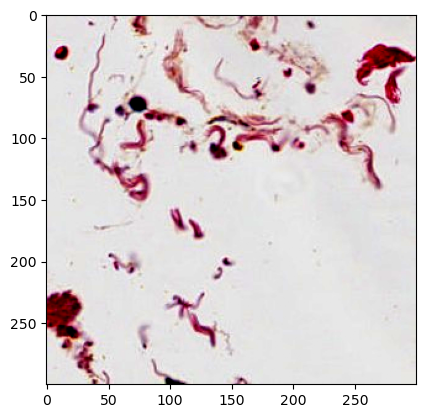

In [ ]:
# Visualize a random sample from the normalized dataset
index = random.randint(0, len(dataset_2))
image, label = dataset_2[index]
plt.imshow(image.numpy().transpose(1, 2, 0))
print(image.shape, label)

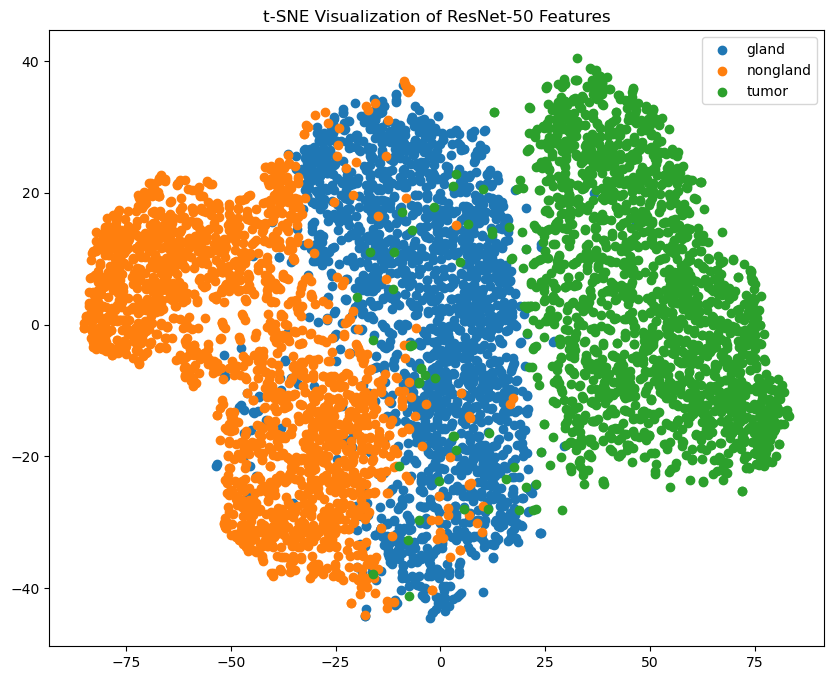

In [ ]:
resnet50.eval()

# Store features and labels
features_list = []
labels_list = []

# Get the features and labels
for data in data_loader_2:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    features = resnet50(inputs).detach().cpu().numpy()
    features_list.append(features)
    labels_list.append(labels.cpu().numpy())

# Concatenate features and labels
features = torch.from_numpy(np.concatenate(features_list))
labels = torch.from_numpy(np.concatenate(labels_list))

# Reshape the features tensor if needed
features = features.view(features.size(0), -1)  # Reshape if necessary for t-SNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(features)

# Verbal class labels.
class_labels = ["gland", "nongland", "tumor"]

# Plot the t-SNE embedded features with class labels
plt.figure(figsize=(10, 8))
for class_idx in range(3):
    plt.scatter(
        embedded_features[labels == class_idx, 0],
        embedded_features[labels == class_idx, 1],
        label=class_labels[ class_idx],
    )
plt.title('t-SNE Visualization of ResNet-50 Features')
plt.legend()
plt.show()

Resnet50 Trained on ImageNet Feature extraction Dataset 3

In [ ]:
# Download Dataset 3
data_path_3 = 'Dataset 3/Animal Faces'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset_3 = torchvision.datasets.ImageFolder(data_path_3, transforms)

batch_size = 50
data_loader_3 = torch.utils.data.DataLoader(dataset_3, shuffle=True, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) 2


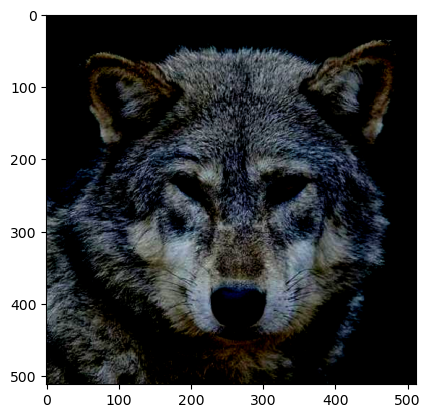

In [ ]:
# Visualize a random sample from the normalized dataset
index = random.randint(0, len(dataset_3))
image, label = dataset_3[index]
plt.imshow(image.numpy().transpose(1, 2, 0))
print(image.shape, label)

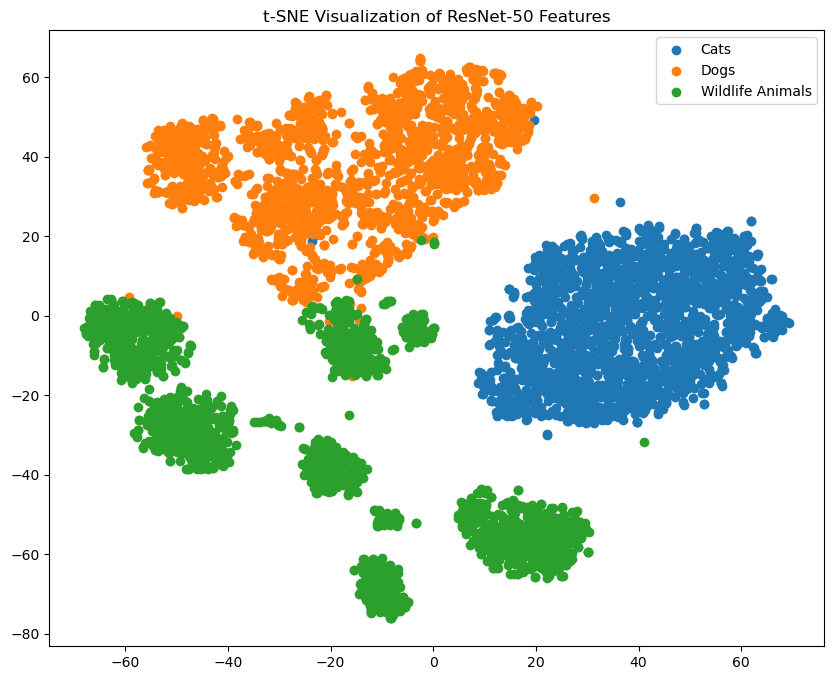

In [ ]:
resnet50.eval()

# Store features and labels
features_list = []
labels_list = []

# Get the features and labels
for data in data_loader_3:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    features = resnet50(inputs).detach().cpu().numpy()
    features_list.append(features)
    labels_list.append(labels.cpu().numpy())

# Concatenate features and labels
features = torch.from_numpy(np.concatenate(features_list))
labels = torch.from_numpy(np.concatenate(labels_list))

# Reshape the features tensor if needed
features = features.view(features.size(0), -1)  # Reshape if necessary for t-SNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(features)

# Verbal class labels.
class_labels = ["Cats", "Dogs", "Wildlife Animals"]

# Plot the t-SNE embedded features with class labels
plt.figure(figsize=(10, 8))
for class_idx in range(3):
    plt.scatter(
        embedded_features[labels == class_idx, 0],
        embedded_features[labels == class_idx, 1],
        label=class_labels[ class_idx],
    )
plt.title('t-SNE Visualization of ResNet-50 Features')
plt.legend()
plt.show()

Classification Learning Models

Supervised learning Technique (SVM) on Dataset 2 of our Trained Resnet-18 model

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       408
           1       0.86      0.86      0.86       385
           2       0.97      0.97      0.97       407

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



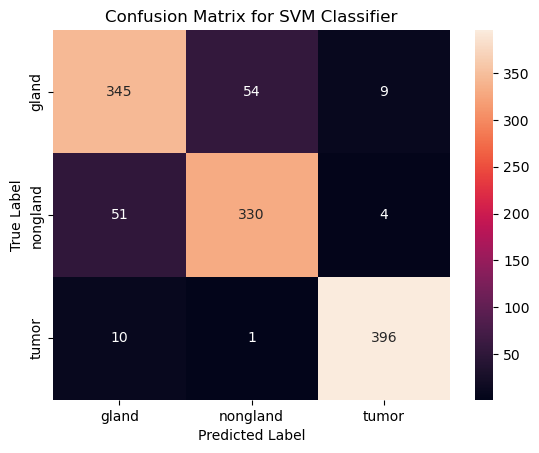

In [ ]:
from sklearn.svm import SVC

# Load the features and labels
features = np.load('extracted_features.npy')
labels = np.load('labels.npy')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train an SVM classifier
classifier = SVC()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

# Display the confusion matrix.
class_labels = ["gland", "nongland", "tumor"]
cm_train = sklearn.metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(cm_train, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for SVM Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

K-Nearest Neighbors Classifier (KNN) on Dataset 2 of our Trained Resnet-18 model

              precision    recall  f1-score   support

       gland       0.90      1.00      0.95      1592
    nongland       1.00      0.91      0.95      1615
       tumor       1.00      0.98      0.99      1593

    accuracy                           0.96      4800
   macro avg       0.97      0.96      0.96      4800
weighted avg       0.97      0.96      0.96      4800



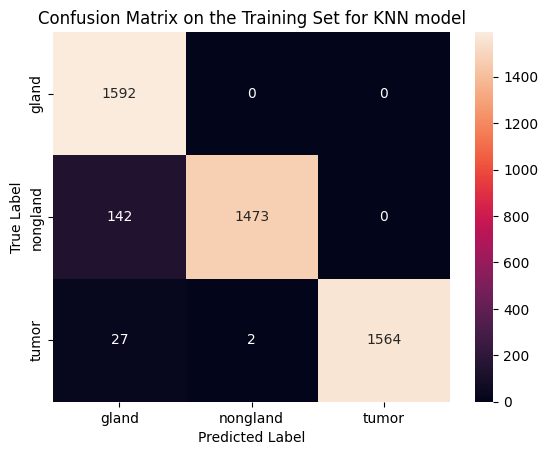

              precision    recall  f1-score   support

       gland       0.85      0.91      0.88       408
    nongland       0.91      0.85      0.88       385
       tumor       0.99      0.97      0.98       407

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200



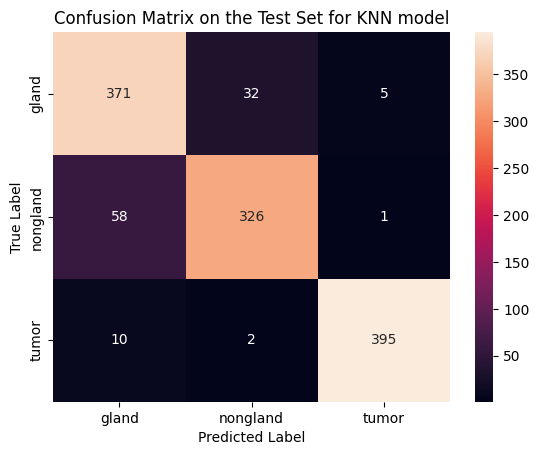

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load the features and labels
features = np.load('extracted_features.npy')
labels = np.load('labels.npy')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

#create different models to see mean accuracy for different K values
#scores = np.zeros((20,))
#kvalues = np.arange(1,21,1)
#for i in kvalues:
#  KNNmodel = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=i))
#  KNNmodel.fit(X_train, y_train)
#  scores[i-1] = KNNmodel.score(X_test, y_test)
#plt.plot(kvalues, scores)
#plt.title("Score of model prediction on test set with weights='uniform'")
#plt.ylabel('Mean Accuracy')
#plt.xlabel('k values')
#plt.show()

#Make model with StandardScaler and fit the data
KNNmodel = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=2))
KNNmodel.fit(X_train, y_train)

#predictions on both sets
test_pred = KNNmodel.predict(X_test)
train_pred = KNNmodel.predict(X_train)

#results on the training set
class_labels = ["gland", "nongland", "tumor"]
print(classification_report(y_train, train_pred, target_names=class_labels))

cm_train = sklearn.metrics.confusion_matrix(y_train, train_pred)
sns.heatmap(cm_train, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix on the Training Set for KNN model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#results on the training set
print(classification_report(y_test, test_pred, target_names=class_labels))
cm_train = sklearn.metrics.confusion_matrix(y_test, test_pred)
sns.heatmap(cm_train, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix on the Test Set for KNN model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()